# Model Development

In [1]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import tqdm
import re
import pandas_profiling
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-paper')

from ml_utils.preprocessing import target_melt
from ml_utils.tools import format_timedelta
import datetime

In [2]:
# from ml_utils.preprocessing import CategoricalEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from category_encoders import MEstimateEncoder, JamesSteinEncoder
from sklearn.preprocessing import MinMaxScaler
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import ADASYN
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, \
                            roc_curve, \
                            auc, \
                            classification_report, \
                            confusion_matrix, \
                            accuracy_score, \
                            precision_score, \
                            recall_score, \
                            f1_score

In [3]:
import shap
shap.initjs()

In [96]:
import optunity
import optunity.metrics

In [4]:
vcdb = pd.read_excel('data/vcdb_decoded.xlsx')

In [5]:
pd.__version__

'1.0.1'

In [6]:
with open('data/vcdb-enum.json') as f:
    enums = json.load(f)
    
with open('data/vcdb-merged.json') as f:
    schema = json.load(f)

In [7]:
keynames = []
with open('data/vcdb-keynames-real.txt') as f:
    for line in f:
        keynames.append(line.replace('\n', ''))
        

# Creating a configuration file / data dictionary

In [8]:
config = {
    'base_data': {},
    'targets': {}
}

# One-hot encoded features

In [9]:
ohe_cols = [col for col in vcdb if vcdb[col].isin([True, False]).all()]
print('%s hot encoded features'%len(ohe_cols))
      
assert vcdb[ohe_cols].notnull().all().all()
assert len(ohe_cols) == len(vcdb.select_dtypes('bool').columns)

476 hot encoded features


In [10]:
config['base_data']['one-hot encoded'] = ohe_cols

# Null Columns

In [11]:
null_cols = vcdb.columns[vcdb.isnull().all()]
null_cols = [col for col in null_cols if col not in ohe_cols]
print('%s completely null features'%len(null_cols))
config['base_data']['all null'] = null_cols

91 completely null features


Some of these are fine because they are one_hot encoded columns

In [12]:
some_nulls = [col for col in vcdb.columns[vcdb.isnull().any()] if col not in null_cols]
print('%s features with some nulls'%len(some_nulls))
config['base_data']['some null'] = some_nulls

115 features with some nulls


## Null categorical features with an Unknown category
We replace columns with "Unknown" as a value with pandas nulls, this way we can figure out a good imputation strategy for these rather than treat "unknown" as a category, since it is not useful to us.

In [13]:
ukn_cols = [col for col in some_nulls if (vcdb[col].astype(str).str.lower()=='unknown').any()]
for col in ukn_cols:
    vcdb.loc[vcdb[col].astype(str).str.lower()=='unknown', col] = None

assert not vcdb[ukn_cols].apply(lambda col: (col.astype(str).str.lower()=='unknown').any()).any()
config['base_data']['explicitly unknown'] = ukn_cols

# Data Types

### Floats

In [14]:
vcdb.select_dtypes('float64').notnull().sum().sort_values(ascending=False)

attribute.confidentiality.data_total                 4394
attribute.confidentiality.data.amount.Medical        1711
attribute.confidentiality.data.amount.Personal       1192
victim.locations_affected                            1185
victim.revenue.amount                                 505
                                                     ... 
asset.assets.amount.U - Telephone                       0
asset.assets.amount.U - Unknown                         0
asset.assets.amount.U - VoIP phone                      0
attribute.confidentiality.data.amount.Source code       0
asset.assets.amount.E - Other                           0
Length: 149, dtype: int64

In [15]:
vcdb.dtypes.value_counts()

bool       476
float64    149
object      66
int64        1
dtype: int64

In [16]:
float_cols = [col for col in vcdb.select_dtypes('float64') if not vcdb[col].isnull().all()]
len(float_cols)
config['base_data']['floats'] = float_cols

## Free Text

In [17]:
text_cols = [col for col in vcdb if 'notes' in col.lower() or 'summary' in col.lower()]
text_cols += ['reference']
text_cols

['action.environmental.notes',
 'action.error.notes',
 'action.hacking.notes',
 'action.malware.notes',
 'action.misuse.notes',
 'action.physical.notes',
 'action.social.notes',
 'action.unknown.notes',
 'asset.notes',
 'attribute.availability.notes',
 'attribute.confidentiality.notes',
 'attribute.integrity.notes',
 'discovery_notes',
 'impact.notes',
 'notes',
 'plus.analyst_notes',
 'plus.event_chain.summary',
 'plus.pci.notes',
 'summary',
 'victim.notes',
 'victim.secondary.notes',
 'reference']

In [18]:
vcdb[text_cols].notnull().sum()

action.environmental.notes            1
action.error.notes                  299
action.hacking.notes                192
action.malware.notes                102
action.misuse.notes                 118
action.physical.notes                30
action.social.notes                  60
action.unknown.notes                  5
asset.notes                         173
attribute.availability.notes        114
attribute.confidentiality.notes     727
attribute.integrity.notes           234
discovery_notes                     415
impact.notes                        133
notes                               423
plus.analyst_notes                  167
plus.event_chain.summary              0
plus.pci.notes                        0
summary                            7329
victim.notes                         62
victim.secondary.notes               74
reference                          7379
dtype: int64

## Text cleaning

In [19]:
cat_and_text_cols = vcdb.select_dtypes('O').columns
for col in cat_and_text_cols:
    vcdb[col] = (
        vcdb[col]
            .fillna('placeholder_nan')
            .astype(str)
            .str.lower()
            .replace('placeholder_nan', np.nan)
    )

## Categoricals

In [20]:
{col: vcdb[col].unique() for col in vcdb if 'cve' in col}

{'action.hacking.cve': array([nan, 'cve-2008-4250', 'heartbleed', 'cve-2012-0507',
        'unknown vuln', 'cve-2016-6483', 'cve unknown', 'cve-2012-5385',
        'cve-2014-0160', 'cve-2017-5638', 'cve-2012-4969', 'cve-2013-0632',
        'cve-2013-1347,cve-2013-2423,cve-2013-1493', 'cve-2017-0144',
        'wordpress'], dtype=object),
 'action.malware.cve': array([nan, 'cve-2010-0249',
        'cve-2009-3129, cve-2010-3333, cve-2012-0158, cve-2011-3544',
        'cve-2013-0640,cve-2013-0641', 'cve-2012-4681;cve-2013-2423',
        'cve-2013-3893', 'cve 2012-4792',
        'cve-2013-1347, cve-2013-2423, cve-2013-1493', 'cve-2012-4681'],
       dtype=object)}

In [21]:
feature_counts = {}
for col in vcdb.select_dtypes('O'):
    if 'notes' not in col.lower() and col not in ohe_cols:
        feature_counts[col]= vcdb[col].nunique()
feature_counts

{'action.hacking.cve': 14,
 'action.malware.cve': 8,
 'action.malware.name': 21,
 'campaign_id': 10,
 'control_failure': 1,
 'incident_id': 7829,
 'plus.analyst': 69,
 'plus.asset.total': 3,
 'plus.attribute.confidentiality.credit_monitoring': 5,
 'plus.attribute.confidentiality.data_abuse': 3,
 'plus.attribute.confidentiality.data_misuse': 4,
 'plus.attribute.confidentiality.partner_data': 2,
 'plus.f500': 6,
 'plus.github': 4344,
 'plus.master_id': 7832,
 'plus.sub_source': 4,
 'reference': 5925,
 'schema_version': 2,
 'source_id': 1,
 'summary': 6936,
 'victim.industry': 670,
 'victim.region': 38,
 'victim.secondary.victim_id': 234,
 'victim.state': 97,
 'victim.victim_id': 5616,
 'victim.industry3': 115,
 'victim.industry.name': 21,
 'pattern': 10,
 'security_incident': 3,
 'impact.overall_rating': 4,
 'impact.iso_currency_code': 10,
 'confidence': 4,
 'victim.employee_count': 11,
 'victim.country': 134,
 'victim.revenue.iso_currency_code': 2,
 'victim.orgsize': 2,
 'attribute.avai

In [22]:
vcdb[feature_counts.keys()]

,action.hacking.cve,action.malware.cve,action.malware.name,campaign_id,control_failure,incident_id,plus.analyst,plus.asset.total,plus.attribute.confidentiality.credit_monitoring,plus.attribute.confidentiality.data_abuse,...,targeted,cost_corrective_action,asset.cloud,asset.accessibility,asset.country,plus.analysis_status,plus.attack_difficulty_initial,plus.attack_difficulty_legacy,plus.attack_difficulty_subsequent,plus.unknown_unknowns
0,NaN,NaN,NaN,NaN,NaN,0001aa7f-c601-424a-b2b8-be6c9f5164e7,swidup,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,first pass,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,0008dadb-e83d-4278-a19a-cee01610cf43,swidup,NaN,u,NaN,...,NaN,NaN,NaN,NaN,NaN,first pass,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,000d403e-2dc9-4ea7-9294-bd3938d1c3c7,swidup,NaN,y,NaN,...,NaN,NaN,NaN,NaN,NaN,first pass,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,0012cc25-9167-40d8-8fe3-3d0dfd8fb6bb,swidup,no,u,y,...,NaN,NaN,NaN,NaN,NaN,first pass,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,00163384-b4d7-46d5-9e6f-543dfb00f598,swidup,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,first pass,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7828,NaN,NaN,NaN,NaN,NaN,b533254c-4713-4fe7-a9f8-412abb4ec664,robert-topper,NaN,u,NaN,...,NaN,NaN,NaN,NaN,NaN,finalized,NaN,NaN,NaN,NaN
7829,NaN,NaN,NaN,NaN,NaN,ffd31fe4-976b-48ca-a111-ef84ebab9b0f,swidup,NaN,y,NaN,...,NaN,NaN,NaN,NaN,NaN,first pass,NaN,NaN,NaN,NaN
7830,NaN,NaN,NaN,NaN,NaN,ffda2281-8053-4315-b613-330eb09a4bee,swidup,no,u,y,...,NaN,NaN,NaN,NaN,NaN,first pass,NaN,NaN,NaN,NaN
7831,NaN,NaN,NaN,NaN,NaN,ffdc6655-e421-4bec-835f-1bdfec4f6c70,swidup,no,u,u,...,NaN,NaN,NaN,NaN,NaN,first pass,NaN,NaN,NaN,NaN


In [23]:
def id_generator(dict_var, key):
    """
    Based.
    https://stackoverflow.com/questions/21028979/recursive-iteration-through-nested-json-for-specific-key-in-python
    """
    for k, v in dict_var.items():
        if k == key:
            yield v
        elif isinstance(v, dict):
            for id_val in id_generator(v, key):
                yield id_val

In [24]:
enums = set()
for enum in id_generator(schema,'enum'):
    enums.add(tuple(enum))

len(enums)

66

In [25]:
pd.Categorical(vcdb['security_incident']).categories

Index(['confirmed', 'near miss', 'suspected'], dtype='object')

# Target Variable Analysis

We start by having at some Incident Description Enumerations to see what is feasible.

#### SECURITY_INCIDENT
- Confirmed: Yes - Confirmed
- Suspected: Suspected
- False positive: False positive (response triggered, but no incident)
- Near miss: Near miss (actions did not compromise asset)

In [26]:
config['targets']['All'] = []

In [27]:
schema['properties']['security_incident']

{'type': 'string',
 'description': 'Confirmed incident?',
 'enum': ['Confirmed', 'Suspected', 'Near miss', 'False positive']}

In [28]:
vcdb['security_incident'].value_counts(dropna=False)

confirmed    7759
suspected      67
near miss       6
NaN             1
Name: security_incident, dtype: int64

In [29]:
config['targets']['All'].append('security_incident')

In [30]:
impact_cols = [col for col in vcdb if col.startswith('impact')]

In [31]:
vcdb[[col for col in vcdb if col.startswith('impact')]].notnull().sum()

impact.loss.amount             0
impact.notes                 133
impact.overall_amount         80
impact.overall_max_amount      1
impact.overall_min_amount      2
impact.overall_rating         27
impact.iso_currency_code     197
dtype: int64

In [32]:
vcdb['impact.overall_rating'].value_counts(dropna=False)

NaN              7806
distracting        13
damaging            8
painful             5
insignificant       1
Name: impact.overall_rating, dtype: int64

In [33]:
config['targets']['All'] += [col for col in vcdb if col.startswith('impact')]

# Predicting C-I-A outcomes

In [34]:
cia_cols = [col for col in vcdb if col.startswith('attribute.')]
config['targets']['All CIA'] = cia_cols

Data Disclosure looks promising as a decision outcome: while there is a class imbalance it is not as extreme as that of security_incidents

In [35]:
vcdb['attribute.confidentiality.data_disclosure'].value_counts()

yes            5076
potentially    1884
no               76
Name: attribute.confidentiality.data_disclosure, dtype: int64

In [154]:
vcdb['attribute.Confidentiality'].value_counts()

True     7249
False     584
Name: attribute.Confidentiality, dtype: int64

In [152]:
vcdb['attribute.Integrity'].value_counts()

False    5998
True     1835
Name: attribute.Integrity, dtype: int64

In [153]:
vcdb['attribute.Availability'].value_counts()

False    5486
True     2347
Name: attribute.Availability, dtype: int64

In [36]:
config['targets']['data_disclosure'] = 'attribute.confidentiality.data_disclosure'

Availability Duration does not seem promising as a decision outcome

In [37]:
config['targets']['All'] += [col for col in vcdb if col.startswith('attribute')]

In [38]:
vcdb['attribute.Confidentiality'].value_counts()

True     7249
False     584
Name: attribute.Confidentiality, dtype: int64

In [40]:
vcdb['attribute.Integrity'].value_counts()

False    5998
True     1835
Name: attribute.Integrity, dtype: int64

In [42]:
vcdb['attribute.Availability'].value_counts()

False    5486
True     2347
Name: attribute.Availability, dtype: int64

In [39]:
[col for col in vcdb if col.startswith('attribute.confidentiality') and 'variety' in col]

['attribute.confidentiality.data.variety.Bank',
 'attribute.confidentiality.data.variety.Classified',
 'attribute.confidentiality.data.variety.Copyrighted',
 'attribute.confidentiality.data.variety.Credentials',
 'attribute.confidentiality.data.variety.Digital certificate',
 'attribute.confidentiality.data.variety.Internal',
 'attribute.confidentiality.data.variety.Medical',
 'attribute.confidentiality.data.variety.Other',
 'attribute.confidentiality.data.variety.Payment',
 'attribute.confidentiality.data.variety.Personal',
 'attribute.confidentiality.data.variety.Secrets',
 'attribute.confidentiality.data.variety.Source code',
 'attribute.confidentiality.data.variety.System',
 'attribute.confidentiality.data.variety.Unknown',
 'attribute.confidentiality.data.variety.Virtual currency']

In [41]:
[col for col in vcdb if col.startswith('attribute.integrity')]

['attribute.integrity.notes',
 'attribute.integrity.variety.Alter behavior',
 'attribute.integrity.variety.Created account',
 'attribute.integrity.variety.Defacement',
 'attribute.integrity.variety.Fraudulent transaction',
 'attribute.integrity.variety.Hardware tampering',
 'attribute.integrity.variety.Log tampering',
 'attribute.integrity.variety.Misrepresentation',
 'attribute.integrity.variety.Modify configuration',
 'attribute.integrity.variety.Modify data',
 'attribute.integrity.variety.Modify privileges',
 'attribute.integrity.variety.Other',
 'attribute.integrity.variety.Repurpose',
 'attribute.integrity.variety.Software installation',
 'attribute.integrity.variety.Unknown']

In [43]:
[col for col in vcdb if col.startswith('attribute.availability')]

['attribute.availability.duration.value',
 'attribute.availability.notes',
 'attribute.availability.variety.Acceleration',
 'attribute.availability.variety.Degradation',
 'attribute.availability.variety.Destruction',
 'attribute.availability.variety.Interruption',
 'attribute.availability.variety.Loss',
 'attribute.availability.variety.Obscuration',
 'attribute.availability.variety.Other',
 'attribute.availability.variety.Unknown',
 'attribute.availability.duration.unit']

In [44]:
vcdb['attribute.availability.duration.value'].notnull().sum()

106

In [45]:
vcdb['control_failure'].value_counts(dropna=False)

NaN                             7832
single factor authentication       1
Name: control_failure, dtype: int64

## Predicting Pattern Outcomes

In [46]:
vcdb['pattern'].value_counts()

miscellaneous errors      1812
privilege misuse          1597
lost and stolen assets    1460
everything else           1026
web applications           896
payment card skimmers      278
crimeware                  267
cyber-espionage            247
denial of service          162
point of sale               88
Name: pattern, dtype: int64

In [47]:
config['targets']['All'].append('pattern')

In [48]:
pattern_cols = [col for col in vcdb if col.startswith('pattern.')]
pattern_cols

['pattern.Point of Sale',
 'pattern.Web Applications',
 'pattern.Privilege Misuse',
 'pattern.Lost and Stolen Assets',
 'pattern.Miscellaneous Errors',
 'pattern.Crimeware',
 'pattern.Payment Card Skimmers',
 'pattern.Denial of Service',
 'pattern.Cyber-Espionage',
 'pattern.Everything Else']

In [49]:
vcdb[pattern_cols].sum(axis=1).value_counts()

1    7732
2     101
dtype: int64

In [50]:
target_melt(vcdb, pattern_cols)['target'].value_counts(dropna=False)

Miscellaneous Errors      1812
Privilege Misuse          1604
Lost and Stolen Assets    1505
Everything Else           1026
Web Applications           900
Payment Card Skimmers      290
Cyber-Espionage            280
Crimeware                  267
Denial of Service          162
Point of Sale               88
Name: target, dtype: int64

In [51]:
config['targets']['All'] += pattern_cols

## Asset Cols

In [52]:
asset_cols = [col for col in vcdb if col.startswith('asset.')]
len(asset_cols)

220

## Actions as Outcomes or Features

In [53]:
action_cols = [col for col in vcdb if col.startswith('action.')]

In [54]:
vcdb['action.Social'].value_counts()

False    7318
True      515
Name: action.Social, dtype: int64

#### Action Results are very null

In [55]:
vcdb[[col for col in vcdb if col.startswith('action.') and 'result' in col]].sum(axis=1).value_counts()

0    7555
1     199
2      77
3       2
dtype: int64

#### Action Variety Cols  
Potentially useful for making predictions

Should we melt these to create separate records

In [56]:
action_variety_cols = [col for col in vcdb if col.startswith('action.') and 'variety' in col]
len(action_variety_cols)

155

In [57]:
vcdb[action_variety_cols].sum(axis=1).value_counts()

1     6273
2      935
0      210
3      172
13      88
9       74
4       42
5       26
6        9
7        3
8        1
dtype: int64

In [58]:
target_melt(vcdb, action_variety_cols, split=False)['target'].value_counts()

action.hacking.variety.Unknown                1334
action.physical.variety.Theft                 1128
action.misuse.variety.Privilege abuse         1110
action.error.variety.Misdelivery               910
action.error.variety.Loss                      391
                                              ... 
action.hacking.variety.Session prediction        1
action.hacking.variety.Reverse engineering       1
action.error.variety.Misinformation              1
action.environmental.variety.Humidity            1
action.social.variety.Spam                       1
Name: target, Length: 109, dtype: int64

#### Action Vector Cols  
Potentially useful for making predictions

Should we melt these to create separate records

In [59]:
action_vector_cols = [col for col in vcdb if col.startswith('action.') and 'vector' in col]
len(action_vector_cols)

66

In [60]:
vcdb[action_vector_cols].sum(axis=1).value_counts()

1    6797
2     535
3     251
0     217
4      29
5       3
6       1
dtype: int64

#### Action Result Cols  
Potentially useful for making predictions

Should we melt these to create separate records

In [61]:
action_result_cols = [col for col in vcdb if col.startswith('action.') and 'result' in col]

In [62]:
target_melt(vcdb, action_result_cols, split=False)['target'].shape

(359,)

In [63]:
target_melt(vcdb, action_result_cols, split=False)['target'].value_counts()

action.misuse.result.Exfiltrate      82
action.hacking.result.Exfiltrate     63
action.physical.result.Exfiltrate    55
action.hacking.result.Infiltrate     49
action.malware.result.Exfiltrate     30
action.social.result.Exfiltrate      21
action.social.result.Infiltrate      15
action.malware.result.Infiltrate     14
action.physical.result.Infiltrate    10
action.misuse.result.Infiltrate       5
action.unknown.result.Infiltrate      5
action.unknown.result.Exfiltrate      4
action.social.result.Elevate          3
action.malware.result.Elevate         1
action.hacking.result.Elevate         1
action.physical.result.Elevate        1
Name: target, dtype: int64

In [64]:
target_melt(vcdb, action_vector_cols, split=False)['target'].value_counts()

action.error.vector.Unknown                  1301
action.hacking.vector.Web application        1028
action.misuse.vector.LAN access              1026
action.error.vector.Carelessness              895
action.hacking.vector.Unknown                 769
                                             ... 
action.hacking.vector.3rd party desktop         2
action.malware.vector.Software update           2
action.physical.vector.Visitor privileges       1
action.social.vector.IM                         1
action.social.vector.Removable media            1
Name: target, Length: 64, dtype: int64

In [65]:
vcdb[action_vector_cols].sum(axis=1).value_counts()

1    6797
2     535
3     251
0     217
4      29
5       3
6       1
dtype: int64

### High Level Action
Potentially quite useful as a target variable?

i.e given properties about an organisation, what actions are most likely?

In [66]:
action_target_cols = [col for col in vcdb if col.startswith('action') and col.count('.')==1]
target_melt(vcdb, action_target_cols)['target'].value_counts(dropna=False)

Error            2266
Hacking          2078
Misuse           1604
Physical         1517
Malware           633
Social            515
Unknown           233
Environmental       8
Name: target, dtype: int64

## plus

In [67]:
plus_cia_cols = [col for col in vcdb if col.startswith('plus.') and ('confidentiality' in col.lower() or 'integrity' in col.lower() or 'availability' in col.lower())]

## Fortune 500 company

In [68]:
vcdb['plus.f500'].value_counts(dropna=False)

NaN      6751
n         861
u         152
y          62
no          5
yes         1
false       1
Name: plus.f500, dtype: int64

In [69]:
vcdb['plus.f500'] = (
    vcdb['plus.f500']
        .fillna('u')
        .map({'y': True,
              'yes': True,
              'n': False,
              'no': False,
              'false': False,
              'u': None
             })
)

In [70]:
vcdb['plus.f500'].value_counts(dropna=False)

True     6903
False     867
True       63
Name: plus.f500, dtype: int64

# Model 2: Predicting CIA

In [71]:
id_cols = [col for col in vcdb if '_id' in col]
id_cols += ['plus.github']

In [72]:
y_confidentiality = vcdb['attribute.Confidentiality'].values

In [73]:
y_integrity = vcdb['attribute.Integrity'].values

In [74]:
y_availability = vcdb['attribute.Availability'].values

In [75]:
pattern_cols

['pattern.Point of Sale',
 'pattern.Web Applications',
 'pattern.Privilege Misuse',
 'pattern.Lost and Stolen Assets',
 'pattern.Miscellaneous Errors',
 'pattern.Crimeware',
 'pattern.Payment Card Skimmers',
 'pattern.Denial of Service',
 'pattern.Cyber-Espionage',
 'pattern.Everything Else']

In [76]:
dropped_cols = (
    id_cols + 
    text_cols + 
    cia_cols + 
    impact_cols + 
    pattern_cols + 
    null_cols + 
    plus_cia_cols + 
    ['pattern', 'security_incident', 'plus.analyst', 'plus.analysis_status', 'schema_version', 'targeted']
)


In [77]:
X = (
    vcdb
        .copy()
        .drop(labels = dropped_cols, axis=1)
)
X['victim.industry2'] = X['victim.industry2'].astype(str)
assert X.select_dtypes('int64').empty
cat_cols = list(X.select_dtypes('O').columns)

In [78]:
X_noaction = (
    vcdb
        .copy()
        .drop(labels = dropped_cols + action_cols, axis=1)
)
X_noaction['victim.industry2'] = X_noaction['victim.industry2'].astype(str)
assert X_noaction.select_dtypes('int64').empty

In [79]:
X_noasset = (
    vcdb
        .copy()
        .drop(labels = dropped_cols + asset_cols, axis=1)
)
X_noasset['victim.industry2'] = X_noasset['victim.industry2'].astype(str)
assert X_noasset.select_dtypes('int64').empty

In [80]:
X_noactionasset = (
    vcdb
        .copy()
        .drop(labels = dropped_cols + asset_cols + action_cols, axis=1)
)
X_noactionasset['victim.industry2'] = X_noactionasset['victim.industry2'].astype(str)
assert X_noactionasset.select_dtypes('int64').empty

In [81]:
X_noactionasset.columns

Index(['control_failure', 'plus.asset_os.Android', 'plus.asset_os.Apple iOS',
       'plus.asset_os.BlackBerry OS', 'plus.asset_os.Linux',
       'plus.asset_os.Mac OSX', 'plus.asset_os.Mainframe',
       'plus.asset_os.Not applicable', 'plus.asset_os.Other',
       'plus.asset_os.Symbian', 'plus.asset_os.Unix', 'plus.asset_os.Unknown',
       'plus.asset_os.webOS', 'plus.asset_os.Windows',
       'plus.asset_os.Windows Phone', 'plus.asset.total',
       'plus.event_chain.actor.ext', 'plus.event_chain.actor.int',
       'plus.event_chain.actor.prt', 'plus.event_chain.actor.unk', 'plus.f500',
       'plus.pci.compliance_status.Found Compliant',
       'plus.pci.compliance_status.Not Compliant',
       'plus.pci.compliance_status.Unknown', 'plus.pci.merchant_level.Level 1',
       'plus.pci.merchant_level.Level 2', 'plus.pci.merchant_level.Level 3',
       'plus.pci.merchant_level.Level 4', 'plus.pci.merchant_level.Unknown',
       'plus.sub_source', 'victim.industry', 'victim.locations_

## Model Comparison

In [137]:
def compare_models(data, labels, exc_cols=[], title='Receiver Operating Characteristic', figsize=(8,5)):
    X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)
    X_train.is_copy = None
    X_val.is_copy = None
    cat_cols = list(data.select_dtypes('O').columns)

    preprocessor = Pipeline(([
        ('encoder', MEstimateEncoder(cols=[col for col in cat_cols if col not in exc_cols])),
        ('imputer', IterativeImputer(verbose=2))
    ]))
    sampler = ADASYN()

    X_train_preprocessed = preprocessor.fit_transform(X_train, y_train)
    X_val_preprocessed = preprocessor.transform(X_val)
    X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_preprocessed, y_train)
    
    models = {
        'XGBoost': {
            'model': XGBClassifier(),
            'c_line' : 'b'
        },
        'Random Forest': {
            'model': RandomForestClassifier(),
            'c_line': 'g'
        },
        'SVM': {
            'model': SVC(probability=True),
            'c_line': 'm'
        },
        'Naive Bayes': {
            'model': GaussianNB(),
            'c_line': 'y'
        }
    }
    
    names = []
    roc_aucs = []
    accuracies = []
    precisions = []
    recalls = []
    f1s = []
    

    fig = plt.figure(figsize=figsize)

    for model_name, model in models.items():

        t0 = datetime.datetime.now()

        print('Fitting %s...\n'%model_name)

        clf = model['model']
        
        if model_name == 'Naive Bayes':
            scaler = MinMaxScaler()
            x_train = scaler.fit_transform(X_train_resampled)
            x_test = scaler.transform(X_val_preprocessed)
        else:
            x_train = X_train_resampled
            x_test = X_val_preprocessed
        y_train = y_train_resampled
        y_test = y_val

        clf.fit(x_train, y_train)

        print('%s Fitted!'%model_name)
        print('Total Time Elapsed - %s'%format_timedelta(datetime.datetime.now()-t0))

        print('---------------------------------------------------')
        print('Predicting on validation data...')
        y_pred_proba = clf.predict_proba(x_test)[:,1]
        y_pred = clf.predict(x_test)

        print('Predictions Completed')
        print('Total Time Elapsed - %s'%format_timedelta(datetime.datetime.now()-t0))
        print('---------------------------------------------------')
        
        names.append(model_name)
        
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        roc_aucs.append(roc_auc)
#         models[model_name]['roc-auc'] = roc_auc

        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
#         models[model_name]['accuracy'] = accuracy

        precision = precision_score(y_test, y_pred)
        precisions.append(precision)
#         models[model_name]['precision'] = precision

        recall = recall_score(y_test, y_pred)
        recalls.append(recall)
#         models[model_name]['recall'] = recall

        f1  = f1_score(y_test, y_pred)
        f1s.append(f1)
#         models[model_name]['f1 score'] = f1


        print('ROC-AUC Score: {:.2%}'.format(roc_auc))
        print('Accuracy Score: {:.2%}'.format(accuracy))
        print('Precision Score: {:.2%}'.format(precision))
        print('Recall Score: {:.2%}'.format(recall))
        print('F1 Score: {:.2%}'.format(f1))
        print('---------------------------------------------------')
        print('Classification Report:')
        print(classification_report(y_test, y_pred))
        print('---------------------------------------------------')
        print('\nConfusion Matrix:')
        confusion = pd.DataFrame(confusion_matrix(y_test, y_pred)).loc[range(2), range(2)]
        print(confusion)
        print('\n\n===================================================')
        fpr, tpr, threshold = roc_curve(y_test, y_pred_proba)
        # fpr, tpr, threshold = roc_curve(y_val, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, models[model_name]['c_line'], label = '%s (AUC = %0.2f)' % (model_name, roc_auc))
    
    results = pd.DataFrame({
        'Model Name': names,
        'Accuracy': accuracies,
        'Precision': precisions,
        'Recall': recalls,
        'F1 Score': f1s,
        'ROC-AUC': roc_aucs
    })
    # make the plot
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title(title)
    plt.savefig('figs/results_figs/%s.png'%title.replace(' ', '_'))
    plt.show()
    
    return results

---
# Predicting Confidentiality

### With Action Columns

[IterativeImputer] Completing matrix with shape (6266, 468)
[IterativeImputer] Ending imputation round 1/10, elapsed time 116.68
[IterativeImputer] Change: 176365.40204378677, scaled tolerance: 130000000.0 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (1567, 468)
[IterativeImputer] Ending imputation round 1/1, elapsed time 0.17
Fitting XGBoost...

XGBoost Fitted!
Total Time Elapsed - 0:0:4
---------------------------------------------------
Predicting on validation data...
Predictions Completed
Total Time Elapsed - 0:0:4
---------------------------------------------------
ROC-AUC Score: 90.79%
Accuracy Score: 94.89%
Precision Score: 96.35%
Recall Score: 98.21%
F1 Score: 97.27%
---------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

       False       0.71      0.54      0.61       117
        True       0.96      0.98      0.97      1450

    accuracy       

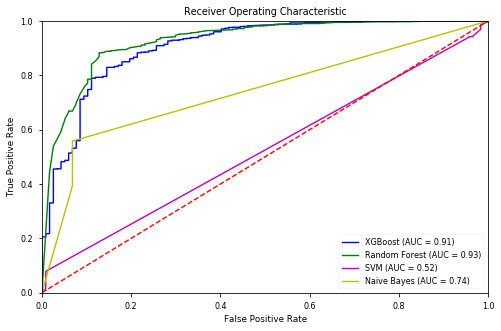

In [93]:
confidentiality_results = compare_models(X, y_confidentiality)

### Without Action Columns

[IterativeImputer] Completing matrix with shape (6266, 200)
[IterativeImputer] Ending imputation round 1/10, elapsed time 14.85
[IterativeImputer] Change: 210874.74090215226, scaled tolerance: 130000000.0 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (1567, 200)
[IterativeImputer] Ending imputation round 1/1, elapsed time 0.12
Fitting XGBoost...

XGBoost Fitted!
Total Time Elapsed - 0:0:3
---------------------------------------------------
Predicting on validation data...
Predictions Completed
Total Time Elapsed - 0:0:3
---------------------------------------------------
ROC-AUC Score: 84.68%
Accuracy Score: 92.60%
Precision Score: 95.01%
Recall Score: 97.10%
F1 Score: 96.04%
---------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

       False       0.51      0.37      0.43       117
        True       0.95      0.97      0.96      1450

    accuracy        

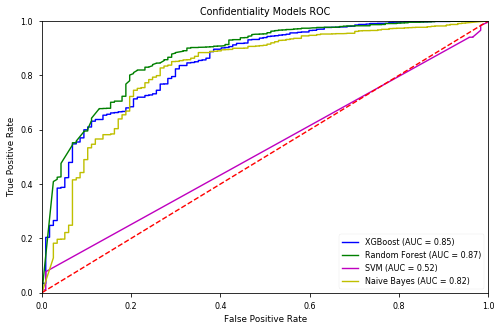

In [138]:
confidentiality_noaction_results = compare_models(X_noaction, y_confidentiality, action_cols, title='Confidentiality Models ROC')

In [141]:
confidentiality_noaction_results.to_clipboard()
confidentiality_noaction_results

,Model Name,Accuracy,Precision,Recall,F1 Score,ROC-AUC
0,XGBoost,0.925973,0.950067,0.971034,0.960437,0.846793
1,Random Forest,0.928526,0.956967,0.966207,0.961565,0.872664
2,SVM,0.137843,0.990099,0.068966,0.128949,0.523548
3,Naive Bayes,0.191449,0.984127,0.128276,0.226968,0.822243


## Confidentiality Model Tuning

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X_noaction, y_confidentiality, test_size=0.2, random_state=42)
# Define our Objective Function
@optunity.cross_validated(x=X_train.values, y=y_train, num_folds=3)
# @optunity.cross_validated(x=X_train_resampled, y=y_train_resampled.values, num_folds=5)
def xgb_tuned_recall(x_train, y_train, x_test, y_test, 
                     # These are the hyperparameters we wish to tune
                     n_estimators,
                     max_depth, 
                     min_child_weight, 
                     gamma, 
                     colsample_bytree,
                     subsample,
                     reg_alpha, 
                     reg_lambda):
    
    # categorical encoding
#     print('M-encoding categoricals')
    x_train_df = pd.DataFrame(x_train, columns = X_noaction.columns)
    x_test_df = pd.DataFrame(x_test, columns = X_noaction.columns)
    cat_cols = list(x_train_df.select_dtypes('O').columns)
    assert all([col in x_train_df for col in cat_cols])
    
    m_encoder = MEstimateEncoder(cols=cat_cols)
    x_train_enc = m_encoder.fit_transform(x_train_df, y_train)
    x_test_enc = m_encoder.transform(x_test_df)
    
    # imputation
#     print('Imputing nulls')
    imputer = IterativeImputer(verbose=0)
    x_train_imp = imputer.fit_transform(x_train_enc)
    x_test = imputer.transform(x_test_enc)
        
    # oversampling
#     print('Oversampling')
    oversampler = ADASYN()
    x_train, y_train = oversampler.fit_resample(x_train_imp, y_train)
    
#     print('Fitting Model')
    model = (
        # instanciate classifier every evaluation
        XGBClassifier(n_estimators = round(n_estimators), 
                      max_depth = round(max_depth),
                      min_child_weight = min_child_weight,
                      gamma = gamma,
                      colsample_bytree = colsample_bytree,
                      subsample = subsample,
                      reg_alpha = reg_alpha,
                      reg_lambda = reg_lambda,
                      verbose = 0
                     )
            # fit model
            ).fit(x_train, y_train)
    
    y_pred = model.predict(x_test)
    y_pred_proba = model.predict_proba(x_test)[:, 1]
    score = recall_score(y_test, y_pred)
    print('Recall Score= {:.2%}'.format(score), '| Total Time Elapsed - %s'%format_timedelta(datetime.datetime.now()-t0))
    return score

t0 = datetime.datetime.now()
print('Tuning XGBoost...')
print('----------------------------\n')

con_optimum, details, _ = optunity.maximize(xgb_tuned_recall, 
                                            num_evals = 100, 
                                            # define hyperparameter grid
                                            n_estimators = [100, 1000], 
                                            max_depth = [2, 10], 
                                            min_child_weight = [1, 7],
                                            gamma = [0.1, 2],
                                            colsample_bytree = [0.3, 1],
                                            subsample = [0.2, 0.7],
                                            reg_alpha = [0, 1],
                                            reg_lambda = [1, 5]
                                           )

print('Tuning Completed!')
print('Total Time Elapsed - %s'%format_timedelta(datetime.datetime.now()-t0))

con_optimum['n_estimators'] = round(con_optimum['n_estimators'])
con_optimum['max_depth'] = round(con_optimum['max_depth'])
con_optimum

Tuning XGBoost...
----------------------------

Recall Score= 96.11% | Total Time Elapsed - 0:0:19
Recall Score= 97.05% | Total Time Elapsed - 0:0:38
Recall Score= 96.08% | Total Time Elapsed - 0:0:56
Recall Score= 96.21% | Total Time Elapsed - 0:1:19
Recall Score= 96.84% | Total Time Elapsed - 0:1:42
Recall Score= 96.39% | Total Time Elapsed - 0:2:5
Recall Score= 96.63% | Total Time Elapsed - 0:2:24
Recall Score= 96.84% | Total Time Elapsed - 0:2:42
Recall Score= 96.65% | Total Time Elapsed - 0:3:1
Recall Score= 96.89% | Total Time Elapsed - 0:3:19
Recall Score= 97.00% | Total Time Elapsed - 0:3:36
Recall Score= 96.29% | Total Time Elapsed - 0:3:53
Recall Score= 95.75% | Total Time Elapsed - 0:4:9
Recall Score= 96.89% | Total Time Elapsed - 0:4:24
Recall Score= 95.87% | Total Time Elapsed - 0:4:40
Recall Score= 96.94% | Total Time Elapsed - 0:4:58
Recall Score= 97.20% | Total Time Elapsed - 0:5:16
Recall Score= 96.08% | Total Time Elapsed - 0:5:34
Recall Score= 96.99% | Total Time Ela

{'n_estimators': 878,
 'max_depth': 8,
 'min_child_weight': 1.013140618517723,
 'gamma': 1.651580078125,
 'colsample_bytree': 0.544876953125,
 'subsample': 0.4349707031249999,
 'reg_alpha': 0.31271484374999997,
 'reg_lambda': 4.006645206640389}

### Evaluating Tuned Confidentiality XGBoost

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X_noaction, y_confidentiality, test_size=0.2, random_state=42)
xgb_preprocessor = Pipeline(([
    ('encoder', MEstimateEncoder(cols=[col for col in cat_cols if col not in action_cols])),
    ('imputer', IterativeImputer(verbose=0))
]))

print('Preprocessing data...')
X_train_preprocessed = xgb_preprocessor.fit_transform(X_train, y_train)
X_test_preprocessed = xgb_preprocessor.transform(X_test)

xgb_sampler = ADASYN()
print('Resampling data...')
X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_preprocessed, y_train)

print('Preprocessing Completed.')
print('----------------------------\n')
xgb = XGBClassifier(**con_optimum)
t0 = datetime.datetime.now()
print('Fitting XGBoost...')
print('----------------------------\n')
xgb.fit(X_train_resampled, y_train_resampled)

print('XGBoost Fitted!')
print('Total Time Elapsed - %s'%format_timedelta(datetime.datetime.now()-t0))

print('Predicting on validation data...')
print('----------------------------\n')
y_pred_proba = xgb.predict_proba(X_test_preprocessed)[:,1]
y_pred = xgb.predict(X_test_preprocessed)

roc_auc = roc_auc_score(y_test, y_pred_proba)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1  = f1_score(y_test, y_pred)

print('ROC-AUC Score: {:.2%}'.format(roc_auc))
print('Accuracy Score: {:.2%}'.format(accuracy))
print('Precision Score: {:.2%}'.format(precision))
print('Recall Score: {:.2%}'.format(recall))
print('F1 Score: {:.2%}'.format(f1))
print('---------------------------------------------------')
print('Classification Report:')
print(classification_report(y_test, y_pred))
print('---------------------------------------------------')
print('\nConfusion Matrix:')
confusion = pd.DataFrame(confusion_matrix(y_test, y_pred)).loc[range(2), range(2)]
print(confusion)
print('\n\n===================================================')
fpr, tpr, threshold = roc_curve(y_test, y_pred_proba)
# fpr, tpr, threshold = roc_curve(y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)

Preprocessing data...
Resampling data...
Preprocessing Completed.
----------------------------

Fitting XGBoost...
----------------------------

XGBoost Fitted!
Total Time Elapsed - 0:0:10
Predicting on validation data...
----------------------------

ROC-AUC Score: 84.96%
Accuracy Score: 91.83%
Precision Score: 94.72%
Recall Score: 96.55%
F1 Score: 95.63%
---------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

       False       0.44      0.33      0.38       117
        True       0.95      0.97      0.96      1450

    accuracy                           0.92      1567
   macro avg       0.69      0.65      0.67      1567
weighted avg       0.91      0.92      0.91      1567

---------------------------------------------------

Confusion Matrix:
    0     1
0  39    78
1  50  1400




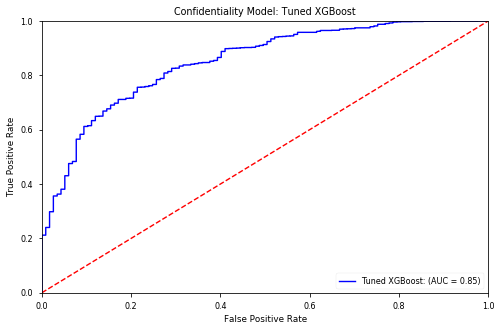

In [104]:
# Plot Results
fig = plt.figure(figsize=(8,5))
plt.plot(fpr, tpr, 'b', label = 'Tuned XGBoost: (AUC = %0.2f)' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Confidentiality Model: Tuned XGBoost')
plt.savefig('figs/results_figs/cia/tuned_xgb_confidentiality.png')
plt.show()

### Confidentiality Interpretability (No Action)
The summary plot combines feature importance with feature effects. Each point on the summary plot is a Shapley value for a feature and an instance. The position on the y-axis is determined by the feature and on the x-axis by the Shapley value. The color represents the value of the feature from low to high. Overlapping points are jittered in y-axis direction, so we get a sense of the distribution of the Shapley values per feature. The features are ordered according to their importance.

In [105]:
preprocessor = Pipeline(([
    ('encoder', MEstimateEncoder(cols=[col for col in cat_cols if col not in action_cols])),
    ('imputer', IterativeImputer(verbose=2))
]))
sampler = ADASYN()

print('Preprocessing data...')

X_preprocessed = preprocessor.fit_transform(X_noaction, y_confidentiality)

print('Resampling data...')
X_resampled, y_confidentiality_resampled = sampler.fit_resample(X_preprocessed, y_confidentiality)

Preprocessing data...
[IterativeImputer] Completing matrix with shape (7833, 205)
[IterativeImputer] Ending imputation round 1/10, elapsed time 15.21
[IterativeImputer] Change: 7016320.712507278, scaled tolerance: 6800000000.0 
[IterativeImputer] Early stopping criterion reached.
Resampling data...


Fiting XGBoost...
SHAP explanations...


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


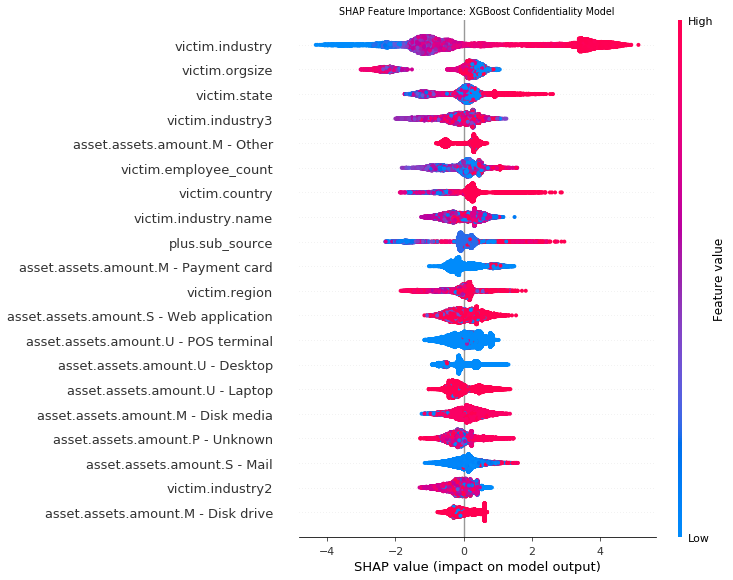

In [106]:
print('Fiting XGBoost...')
xgb_confidentiality = XGBClassifier(**con_optimum)
xgb_confidentiality.fit(X_resampled, y_confidentiality_resampled)

print('SHAP explanations...')
confidentiality_xgb_explainer = shap.TreeExplainer(xgb_confidentiality)
confidentiality_xgb_shap_values = confidentiality_xgb_explainer.shap_values(X_resampled)

plt.title('SHAP Feature Importance: XGBoost Confidentiality Model')
shap.summary_plot(confidentiality_xgb_shap_values, pd.DataFrame(X_resampled, columns=X_noaction.columns))

---
# Predicting Integrity

### With Action Columns

[IterativeImputer] Completing matrix with shape (6266, 468)
[IterativeImputer] Ending imputation round 1/10, elapsed time 111.46
[IterativeImputer] Change: 172046.7656216661, scaled tolerance: 130000000.0 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (1567, 468)
[IterativeImputer] Ending imputation round 1/1, elapsed time 0.17
Fitting XGBoost...

XGBoost Fitted!
Total Time Elapsed - 0:0:3
---------------------------------------------------
Predicting on validation data...
Predictions Completed
Total Time Elapsed - 0:0:3
---------------------------------------------------
ROC-AUC Score: 94.83%
Accuracy Score: 91.64%
Precision Score: 81.85%
Recall Score: 79.71%
F1 Score: 80.76%
---------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

       False       0.94      0.95      0.95      1222
        True       0.82      0.80      0.81       345

    accuracy        

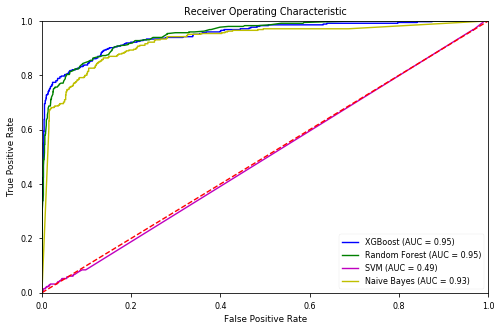

In [107]:
integrity_results = compare_models(X, y_integrity)

### Without Action Columns

[IterativeImputer] Completing matrix with shape (6266, 200)
[IterativeImputer] Ending imputation round 1/10, elapsed time 12.69
[IterativeImputer] Change: 210574.10661685013, scaled tolerance: 130000000.0 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (1567, 200)
[IterativeImputer] Ending imputation round 1/1, elapsed time 0.09
Fitting XGBoost...

XGBoost Fitted!
Total Time Elapsed - 0:0:1
---------------------------------------------------
Predicting on validation data...
Predictions Completed
Total Time Elapsed - 0:0:1
---------------------------------------------------
ROC-AUC Score: 85.82%
Accuracy Score: 85.00%
Precision Score: 66.98%
Recall Score: 62.90%
F1 Score: 64.87%
---------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

       False       0.90      0.91      0.90      1222
        True       0.67      0.63      0.65       345

    accuracy        

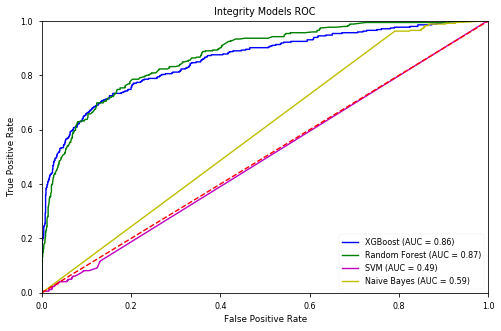

In [142]:
integrity_noaction_results = compare_models(X_noaction, y_integrity, action_cols, title='Integrity Models ROC')

In [143]:
integrity_noaction_results.to_clipboard()
integrity_noaction_results

,Model Name,Accuracy,Precision,Recall,F1 Score,ROC-AUC
0,XGBoost,0.850032,0.669753,0.628986,0.648729,0.858196
1,Random Forest,0.844288,0.643059,0.657971,0.650430,0.871624
2,SVM,0.778558,0.333333,0.005797,0.011396,0.493117
3,Naive Bayes,0.317805,0.242532,0.988406,0.389492,0.586489


## Integrity Model Tuning

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X_noaction, y_integrity, test_size=0.2, random_state=42)
# Define our Objective Function
@optunity.cross_validated(x=X_train.values, y=y_train, num_folds=3)
# @optunity.cross_validated(x=X_train_resampled, y=y_train_resampled.values, num_folds=5)
def xgb_tuned_recall(x_train, y_train, x_test, y_test, 
                     # These are the hyperparameters we wish to tune
                     n_estimators,
                     max_depth, 
                     min_child_weight, 
                     gamma, 
                     colsample_bytree,
                     subsample,
                     reg_alpha, 
                     reg_lambda):
    
    # categorical encoding
#     print('M-encoding categoricals')
    x_train_df = pd.DataFrame(x_train, columns = X_noaction.columns)
    x_test_df = pd.DataFrame(x_test, columns = X_noaction.columns)
    cat_cols = list(x_train_df.select_dtypes('O').columns)
    assert all([col in x_train_df for col in cat_cols])
    
    m_encoder = MEstimateEncoder(cols=cat_cols)
    x_train_enc = m_encoder.fit_transform(x_train_df, y_train)
    x_test_enc = m_encoder.transform(x_test_df)
    
    # imputation
#     print('Imputing nulls')
    imputer = IterativeImputer(verbose=0)
    x_train_imp = imputer.fit_transform(x_train_enc)
    x_test = imputer.transform(x_test_enc)
        
    # oversampling
#     print('Oversampling')
    oversampler = ADASYN()
    x_train, y_train = oversampler.fit_resample(x_train_imp, y_train)
    
#     print('Fitting Model')
    model = (
        # instanciate classifier every evaluation
        XGBClassifier(n_estimators = round(n_estimators), 
                      max_depth = round(max_depth),
                      min_child_weight = min_child_weight,
                      gamma = gamma,
                      colsample_bytree = colsample_bytree,
                      subsample = subsample,
                      reg_alpha = reg_alpha,
                      reg_lambda = reg_lambda,
                      verbose = 0
                     )
            # fit model
            ).fit(x_train, y_train)
    
    y_pred = model.predict(x_test)
    y_pred_proba = model.predict_proba(x_test)[:, 1]
    score = recall_score(y_test, y_pred)
    print('Recall Score= {:.2%}'.format(score), '| Total Time Elapsed - %s'%format_timedelta(datetime.datetime.now()-t0))
    return score

t0 = datetime.datetime.now()
print('Tuning XGBoost...')
print('----------------------------\n')

int_optimum, details, _ = optunity.maximize(xgb_tuned_recall, 
                                            num_evals = 100, 
                                            # define hyperparameter grid
                                            n_estimators = [100, 1000], 
                                            max_depth = [2, 10], 
                                            min_child_weight = [1, 7],
                                            gamma = [0.1, 2],
                                            colsample_bytree = [0.3, 1],
                                            subsample = [0.2, 0.7],
                                            reg_alpha = [0, 1],
                                            reg_lambda = [1, 5]
                                           )

print('Tuning Completed!')
print('Total Time Elapsed - %s'%format_timedelta(datetime.datetime.now()-t0))

int_optimum['n_estimators'] = round(int_optimum['n_estimators'])
int_optimum['max_depth'] = round(int_optimum['max_depth'])
int_optimum

Tuning XGBoost...
----------------------------

Recall Score= 59.48% | Total Time Elapsed - 0:0:19
Recall Score= 58.58% | Total Time Elapsed - 0:0:42
Recall Score= 61.63% | Total Time Elapsed - 0:1:4
Recall Score= 62.30% | Total Time Elapsed - 0:1:22
Recall Score= 60.25% | Total Time Elapsed - 0:1:41
Recall Score= 62.02% | Total Time Elapsed - 0:1:59
Recall Score= 60.48% | Total Time Elapsed - 0:2:15
Recall Score= 61.30% | Total Time Elapsed - 0:2:31
Recall Score= 61.05% | Total Time Elapsed - 0:2:47
Recall Score= 58.67% | Total Time Elapsed - 0:3:2
Recall Score= 59.41% | Total Time Elapsed - 0:3:18
Recall Score= 60.08% | Total Time Elapsed - 0:3:34
Recall Score= 60.69% | Total Time Elapsed - 0:3:55
Recall Score= 59.83% | Total Time Elapsed - 0:4:16
Recall Score= 62.40% | Total Time Elapsed - 0:4:37
Recall Score= 60.69% | Total Time Elapsed - 0:4:54
Recall Score= 60.67% | Total Time Elapsed - 0:5:12
Recall Score= 62.79% | Total Time Elapsed - 0:5:30
Recall Score= 59.07% | Total Time El

{'n_estimators': 603,
 'max_depth': 4,
 'min_child_weight': 3.5300905274546652,
 'gamma': 0.512089936369362,
 'colsample_bytree': 0.8869199218750002,
 'subsample': 0.46346679687499986,
 'reg_alpha': 0.2566911968242166,
 'reg_lambda': 3.1822502561786017}

### Evaluating Tuned Integrity XGBoost

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X_noaction, y_integrity, test_size=0.2, random_state=42)
xgb_preprocessor = Pipeline(([
    ('encoder', MEstimateEncoder(cols=[col for col in cat_cols if col not in action_cols])),
    ('imputer', IterativeImputer(verbose=0))
]))

print('Preprocessing data...')
X_train_preprocessed = xgb_preprocessor.fit_transform(X_train, y_train)
X_test_preprocessed = xgb_preprocessor.transform(X_test)

xgb_sampler = ADASYN()
print('Resampling data...')
X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_preprocessed, y_train)

print('Preprocessing Completed.')
print('----------------------------\n')
xgb = XGBClassifier(**int_optimum)
t0 = datetime.datetime.now()
print('Fitting XGBoost...')
print('----------------------------\n')
xgb.fit(X_train_resampled, y_train_resampled)

print('XGBoost Fitted!')
print('Total Time Elapsed - %s'%format_timedelta(datetime.datetime.now()-t0))

print('Predicting on validation data...')
print('----------------------------\n')
y_pred_proba = xgb.predict_proba(X_test_preprocessed)[:,1]
y_pred = xgb.predict(X_test_preprocessed)

roc_auc = roc_auc_score(y_test, y_pred_proba)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1  = f1_score(y_test, y_pred)

print('ROC-AUC Score: {:.2%}'.format(roc_auc))
print('Accuracy Score: {:.2%}'.format(accuracy))
print('Precision Score: {:.2%}'.format(precision))
print('Recall Score: {:.2%}'.format(recall))
print('F1 Score: {:.2%}'.format(f1))
print('---------------------------------------------------')
print('Classification Report:')
print(classification_report(y_test, y_pred))
print('---------------------------------------------------')
print('\nConfusion Matrix:')
confusion = pd.DataFrame(confusion_matrix(y_test, y_pred)).loc[range(2), range(2)]
print(confusion)
print('\n\n===================================================')
fpr, tpr, threshold = roc_curve(y_test, y_pred_proba)
# fpr, tpr, threshold = roc_curve(y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)

Preprocessing data...
Resampling data...
Preprocessing Completed.
----------------------------

Fitting XGBoost...
----------------------------

XGBoost Fitted!
Total Time Elapsed - 0:0:6
Predicting on validation data...
----------------------------

ROC-AUC Score: 84.13%
Accuracy Score: 84.94%
Precision Score: 66.27%
Recall Score: 64.35%
F1 Score: 65.29%
---------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

       False       0.90      0.91      0.90      1222
        True       0.66      0.64      0.65       345

    accuracy                           0.85      1567
   macro avg       0.78      0.78      0.78      1567
weighted avg       0.85      0.85      0.85      1567

---------------------------------------------------

Confusion Matrix:
      0    1
0  1109  113
1   123  222




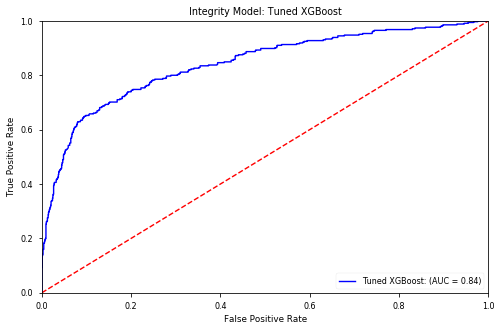

In [134]:
# Plot Results
fig = plt.figure(figsize=(8,5))
plt.plot(fpr, tpr, 'b', label = 'Tuned XGBoost: (AUC = %0.2f)' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Integrity Model: Tuned XGBoost')
plt.savefig('figs/results_figs/cia/tuned_xgb_integrity.png')
plt.show()

### Integrity Interpretability (No Action)
The summary plot combines feature importance with feature effects. Each point on the summary plot is a Shapley value for a feature and an instance. The position on the y-axis is determined by the feature and on the x-axis by the Shapley value. The color represents the value of the feature from low to high. Overlapping points are jittered in y-axis direction, so we get a sense of the distribution of the Shapley values per feature. The features are ordered according to their importance.

In [130]:
preprocessor = Pipeline(([
    ('encoder', MEstimateEncoder(cols=[col for col in cat_cols if col not in action_cols])),
    ('imputer', IterativeImputer(verbose=2))
]))
sampler = ADASYN()

print('Preprocessing data...')

X_preprocessed = preprocessor.fit_transform(X_noaction, y_integrity)

print('Resampling data...')
X_resampled, y_integrity_resampled = sampler.fit_resample(X_preprocessed, y_integrity)

Preprocessing data...
[IterativeImputer] Completing matrix with shape (7833, 205)
[IterativeImputer] Ending imputation round 1/10, elapsed time 17.75
[IterativeImputer] Change: 7018035.690164464, scaled tolerance: 6800000000.0 
[IterativeImputer] Early stopping criterion reached.
Resampling data...


Fiting XGBoost...
SHAP explanations...


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


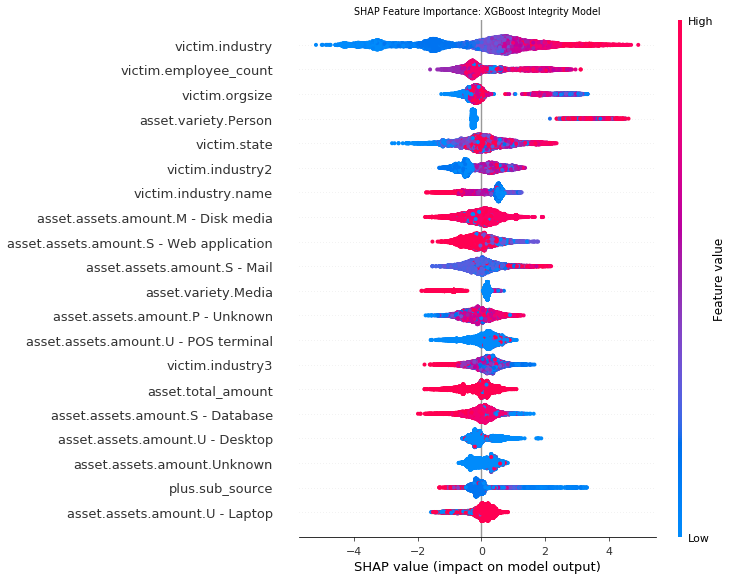

In [131]:
print('Fiting XGBoost...')
xgb_integrity = XGBClassifier(**int_optimum)
xgb_integrity.fit(X_resampled, y_integrity_resampled)

print('SHAP explanations...')
integrity_xgb_explainer = shap.TreeExplainer(xgb_integrity)
integrity_xgb_shap_values = integrity_xgb_explainer.shap_values(X_resampled)

plt.title('SHAP Feature Importance: XGBoost Integrity Model')
shap.summary_plot(integrity_xgb_shap_values, pd.DataFrame(X_resampled, columns=X_noaction.columns))

---
# Predicting Availability

### With Action Columns

[IterativeImputer] Completing matrix with shape (6266, 468)
[IterativeImputer] Ending imputation round 1/10, elapsed time 137.68
[IterativeImputer] Change: 172781.40277932974, scaled tolerance: 130000000.0 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (1567, 468)
[IterativeImputer] Ending imputation round 1/1, elapsed time 0.22
Fitting XGBoost...

XGBoost Fitted!
Total Time Elapsed - 0:0:4
---------------------------------------------------
Predicting on validation data...
Predictions Completed
Total Time Elapsed - 0:0:4
---------------------------------------------------
ROC-AUC Score: 97.58%
Accuracy Score: 93.17%
Precision Score: 90.37%
Recall Score: 86.76%
F1 Score: 88.53%
---------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

       False       0.94      0.96      0.95      1091
        True       0.90      0.87      0.89       476

    accuracy       

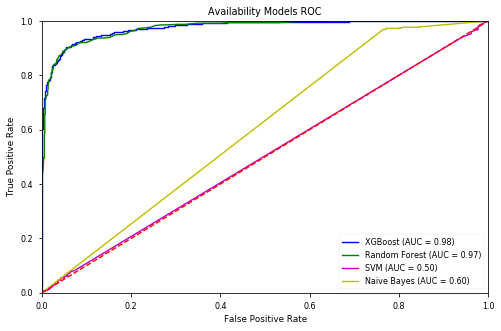

In [116]:
confidentiality_results = compare_models(X, y_availability, title='Availability Models ROC')

### Without Action Columns

[IterativeImputer] Completing matrix with shape (6266, 200)
[IterativeImputer] Ending imputation round 1/10, elapsed time 12.74
[IterativeImputer] Change: 211155.40930613392, scaled tolerance: 130000000.0 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (1567, 200)
[IterativeImputer] Ending imputation round 1/1, elapsed time 0.08
Fitting XGBoost...

XGBoost Fitted!
Total Time Elapsed - 0:0:1
---------------------------------------------------
Predicting on validation data...
Predictions Completed
Total Time Elapsed - 0:0:1
---------------------------------------------------
ROC-AUC Score: 78.54%
Accuracy Score: 76.20%
Precision Score: 62.29%
Recall Score: 54.83%
F1 Score: 58.32%
---------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

       False       0.81      0.86      0.83      1091
        True       0.62      0.55      0.58       476

    accuracy        

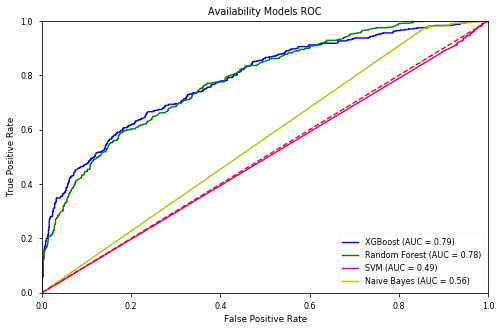

In [148]:
availability_noaction_results = compare_models(X_noaction, y_availability, action_cols, title='Availability Models ROC')

In [150]:
availability_noaction_results.to_clipboard()
availability_noaction_results

,Model Name,Accuracy,Precision,Recall,F1 Score,ROC-AUC
0,XGBoost,0.761966,0.622912,0.548319,0.583240,0.785366
1,Random Forest,0.756860,0.610209,0.552521,0.579934,0.782270
2,SVM,0.675814,0.343137,0.073529,0.121107,0.493481
3,Naive Bayes,0.391193,0.329772,0.972689,0.492553,0.558598


## Availability Model Tuning

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X_noaction, y_availability, test_size=0.2, random_state=42)
# Define our Objective Function
@optunity.cross_validated(x=X_train.values, y=y_train, num_folds=3)
# @optunity.cross_validated(x=X_train_resampled, y=y_train_resampled.values, num_folds=5)
def xgb_tuned_recall(x_train, y_train, x_test, y_test, 
                     # These are the hyperparameters we wish to tune
                     n_estimators,
                     max_depth, 
                     min_child_weight, 
                     gamma, 
                     colsample_bytree,
                     subsample,
                     reg_alpha, 
                     reg_lambda):
    
    # categorical encoding
#     print('M-encoding categoricals')
    x_train_df = pd.DataFrame(x_train, columns = X_noaction.columns)
    x_test_df = pd.DataFrame(x_test, columns = X_noaction.columns)
    cat_cols = list(x_train_df.select_dtypes('O').columns)
    assert all([col in x_train_df for col in cat_cols])
    
    m_encoder = MEstimateEncoder(cols=cat_cols)
    x_train_enc = m_encoder.fit_transform(x_train_df, y_train)
    x_test_enc = m_encoder.transform(x_test_df)
    
    # imputation
#     print('Imputing nulls')
    imputer = IterativeImputer(verbose=0)
    x_train_imp = imputer.fit_transform(x_train_enc)
    x_test = imputer.transform(x_test_enc)
        
    # oversampling
#     print('Oversampling')
    oversampler = ADASYN()
    x_train, y_train = oversampler.fit_resample(x_train_imp, y_train)
    
#     print('Fitting Model')
    model = (
        # instanciate classifier every evaluation
        XGBClassifier(n_estimators = round(n_estimators), 
                      max_depth = round(max_depth),
                      min_child_weight = min_child_weight,
                      gamma = gamma,
                      colsample_bytree = colsample_bytree,
                      subsample = subsample,
                      reg_alpha = reg_alpha,
                      reg_lambda = reg_lambda,
                      verbose = 0
                     )
            # fit model
            ).fit(x_train, y_train)
    
    y_pred = model.predict(x_test)
    y_pred_proba = model.predict_proba(x_test)[:, 1]
    score = recall_score(y_test, y_pred)
    print('Recall Score= {:.2%}'.format(score), '| Total Time Elapsed - %s'%format_timedelta(datetime.datetime.now()-t0))
    return score

t0 = datetime.datetime.now()
print('Tuning XGBoost...')
print('----------------------------\n')

ava_optimum, details, _ = optunity.maximize(xgb_tuned_recall, 
                                            num_evals = 100, 
                                            # define hyperparameter grid
                                            n_estimators = [100, 1000], 
                                            max_depth = [2, 10], 
                                            min_child_weight = [1, 7],
                                            gamma = [0.1, 2],
                                            colsample_bytree = [0.3, 1],
                                            subsample = [0.2, 0.7],
                                            reg_alpha = [0, 1],
                                            reg_lambda = [1, 5]
                                           )

print('Tuning Completed!')
print('Total Time Elapsed - %s'%format_timedelta(datetime.datetime.now()-t0))

ava_optimum['n_estimators'] = round(ava_optimum['n_estimators'])
ava_optimum['max_depth'] = round(ava_optimum['max_depth'])
ava_optimum

Tuning XGBoost...
----------------------------

Recall Score= 57.23% | Total Time Elapsed - 0:0:19
Recall Score= 54.46% | Total Time Elapsed - 0:0:37
Recall Score= 52.32% | Total Time Elapsed - 0:0:56
Recall Score= 56.44% | Total Time Elapsed - 0:1:20
Recall Score= 55.92% | Total Time Elapsed - 0:1:44
Recall Score= 52.96% | Total Time Elapsed - 0:2:9
Recall Score= 55.80% | Total Time Elapsed - 0:2:30
Recall Score= 54.62% | Total Time Elapsed - 0:2:51
Recall Score= 52.00% | Total Time Elapsed - 0:3:13
Recall Score= 58.03% | Total Time Elapsed - 0:3:30
Recall Score= 54.62% | Total Time Elapsed - 0:3:48
Recall Score= 54.08% | Total Time Elapsed - 0:4:5
Recall Score= 58.51% | Total Time Elapsed - 0:4:23
Recall Score= 54.78% | Total Time Elapsed - 0:4:41
Recall Score= 52.96% | Total Time Elapsed - 0:4:59
Recall Score= 54.37% | Total Time Elapsed - 0:5:20
Recall Score= 54.94% | Total Time Elapsed - 0:5:41
Recall Score= 49.44% | Total Time Elapsed - 0:6:1
Recall Score= 58.19% | Total Time Ela

{'n_estimators': 156,
 'max_depth': 8,
 'min_child_weight': 3.0498337558684536,
 'gamma': 1.0201701841724469,
 'colsample_bytree': 0.5901660313782178,
 'subsample': 0.62291015625,
 'reg_alpha': 0.48053276491288194,
 'reg_lambda': 4.359843749999999}

### Evaluating Tuned Availability XGBoost

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X_noaction, y_availability, test_size=0.2, random_state=42)
xgb_preprocessor = Pipeline(([
    ('encoder', MEstimateEncoder(cols=[col for col in cat_cols if col not in action_cols])),
    ('imputer', IterativeImputer(verbose=0))
]))

print('Preprocessing data...')
X_train_preprocessed = xgb_preprocessor.fit_transform(X_train, y_train)
X_test_preprocessed = xgb_preprocessor.transform(X_test)

xgb_sampler = ADASYN()
print('Resampling data...')
X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_preprocessed, y_train)

print('Preprocessing Completed.')
print('----------------------------\n')
xgb = XGBClassifier(**ava_optimum)
t0 = datetime.datetime.now()
print('Fitting XGBoost...')
print('----------------------------\n')
xgb.fit(X_train_resampled, y_train_resampled)

print('XGBoost Fitted!')
print('Total Time Elapsed - %s'%format_timedelta(datetime.datetime.now()-t0))

print('Predicting on validation data...')
print('----------------------------\n')
y_pred_proba = xgb.predict_proba(X_test_preprocessed)[:,1]
y_pred = xgb.predict(X_test_preprocessed)

roc_auc = roc_auc_score(y_test, y_pred_proba)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1  = f1_score(y_test, y_pred)

print('ROC-AUC Score: {:.2%}'.format(roc_auc))
print('Accuracy Score: {:.2%}'.format(accuracy))
print('Precision Score: {:.2%}'.format(precision))
print('Recall Score: {:.2%}'.format(recall))
print('F1 Score: {:.2%}'.format(f1))
print('---------------------------------------------------')
print('Classification Report:')
print(classification_report(y_test, y_pred))
print('---------------------------------------------------')
print('\nConfusion Matrix:')
confusion = pd.DataFrame(confusion_matrix(y_test, y_pred)).loc[range(2), range(2)]
print(confusion)
print('\n\n===================================================')
fpr, tpr, threshold = roc_curve(y_test, y_pred_proba)
# fpr, tpr, threshold = roc_curve(y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)

Preprocessing data...
Resampling data...
Preprocessing Completed.
----------------------------

Fitting XGBoost...
----------------------------

XGBoost Fitted!
Total Time Elapsed - 0:0:2
Predicting on validation data...
----------------------------

ROC-AUC Score: 77.79%
Accuracy Score: 75.69%
Precision Score: 61.34%
Recall Score: 53.99%
F1 Score: 57.43%
---------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

       False       0.81      0.85      0.83      1091
        True       0.61      0.54      0.57       476

    accuracy                           0.76      1567
   macro avg       0.71      0.70      0.70      1567
weighted avg       0.75      0.76      0.75      1567

---------------------------------------------------

Confusion Matrix:
     0    1
0  929  162
1  219  257




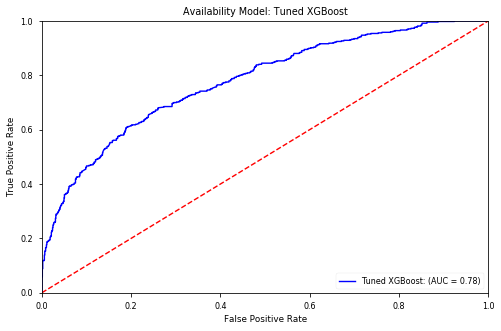

In [132]:
# Plot Results
fig = plt.figure(figsize=(8,5))
plt.plot(fpr, tpr, 'b', label = 'Tuned XGBoost: (AUC = %0.2f)' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Availability Model: Tuned XGBoost')
plt.savefig('figs/results_figs/cia/tuned_xgb_availability.png')
plt.show()

### Availability Interpretability (No Action)
The summary plot combines feature importance with feature effects. Each point on the summary plot is a Shapley value for a feature and an instance. The position on the y-axis is determined by the feature and on the x-axis by the Shapley value. The color represents the value of the feature from low to high. Overlapping points are jittered in y-axis direction, so we get a sense of the distribution of the Shapley values per feature. The features are ordered according to their importance.

In [126]:
preprocessor = Pipeline(([
    ('encoder', MEstimateEncoder(cols=[col for col in cat_cols if col not in action_cols])),
    ('imputer', IterativeImputer(verbose=2))
]))
sampler = ADASYN()

print('Preprocessing data...')

X_preprocessed = preprocessor.fit_transform(X_noaction, y_availability)

print('Resampling data...')
X_resampled, y_availability_resampled = sampler.fit_resample(X_preprocessed, y_availability)

print('Fiting XGBoost...')
xgb_abailability = XGBClassifier(**ava_optimum)
xgb_abailability.fit(X_resampled, y_availability_resampled)

print('SHAP explanations...')
availability_xgb_explainer = shap.TreeExplainer(xgb_abailability)
availability_xgb_shap_values = availability_xgb_explainer.shap_values(X_resampled)

Preprocessing data...
[IterativeImputer] Completing matrix with shape (7833, 205)
[IterativeImputer] Ending imputation round 1/10, elapsed time 16.20
[IterativeImputer] Change: 7019621.1824694555, scaled tolerance: 6800000000.0 
[IterativeImputer] Early stopping criterion reached.
Resampling data...
Fiting XGBoost...
SHAP explanations...


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


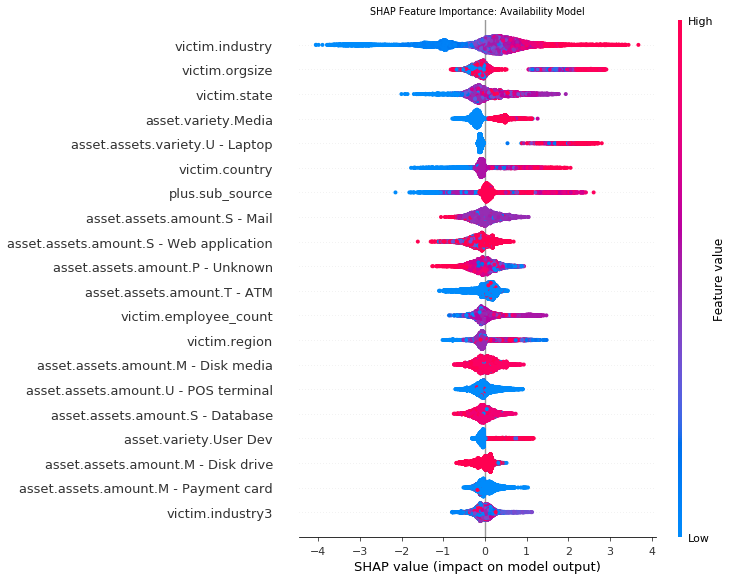

In [128]:
plt.title('SHAP Feature Importance: Availability Model')
shap.summary_plot(availability_xgb_shap_values, pd.DataFrame(X_resampled, columns=X_noaction.columns))